<a href="https://colab.research.google.com/github/paruliansaragi/cnn-fastai/blob/master/Lesson1and2Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai

In [0]:
!wget http://files.fast.ai/data/dogscats.zip

In [0]:
!unzip dogscats.zip

In [0]:
!mkdir data

In [0]:
!mv dogscats data

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [0]:
!pip install torchtext==0.2.3

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=224

In [0]:
torch.cuda.is_available()

True

In [0]:
os.listdir(PATH)

['test1', 'valid', 'models', 'train', 'sample']

In [0]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [0]:
files = os.listdir(f'{PATH}valid/cats')[:6]
files

['cat.772.jpg',
 'cat.379.jpg',
 'cat.5574.jpg',
 'cat.7990.jpg',
 'cat.10773.jpg',
 'cat.4058.jpg']

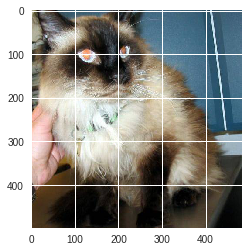

In [0]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [0]:
img.shape
#image is a rank 3 tensor 

(499, 484, 3)

In [0]:
img[:4,:4]
#the 174, 174, 166 represents the rgb pixel values between 0 and 255
#the goal is to predict whever the image is a cat or a dog given these values

array([[[174, 174, 166],
        [180, 177, 168],
        [178, 176, 161],
        [172, 170, 149]],

       [[173, 173, 165],
        [177, 174, 165],
        [175, 173, 158],
        [172, 170, 149]],

       [[171, 171, 161],
        [174, 172, 160],
        [172, 170, 155],
        [172, 170, 149]],

       [[171, 171, 161],
        [173, 171, 158],
        [171, 170, 152],
        [173, 171, 148]]], dtype=uint8)

In [0]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 77530326.38it/s]


100%|██████████| 32/32 [00:14<00:00,  4.40it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.048359   0.029076   0.99      
    1      0.047329   0.029089   0.9905    



[array([0.02909]), 0.9905]

In [0]:
data.val_y
#This is what the validation dataset looks like i.e. the correct answers

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
data.classes
#0 cat 1 dog

['cats', 'dogs']

In [0]:
#data contains the training and validation data
#learn contains the model
#lets make a prediction for the validation set (predictions are in a logs scale):
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [0]:
log_preds[:10]#the output represents a prediction for cats and dogs

array([[ -0.00003, -10.38198],
       [ -0.     , -12.21768],
       [ -0.00123,  -6.69741],
       [ -0.00026,  -8.24339],
       [ -0.00009,  -9.33484],
       [ -0.00025,  -8.31262],
       [ -0.00013,  -8.95211],
       [ -0.00349,  -5.6601 ],
       [ -0.00023,  -8.39583],
       [ -0.00003, -10.41394]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1) # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1]) # probability its a dog

#In pytorch the model returns the log of predictions rather than the probabilities themselves
#To get the probabilities use np.exp()

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


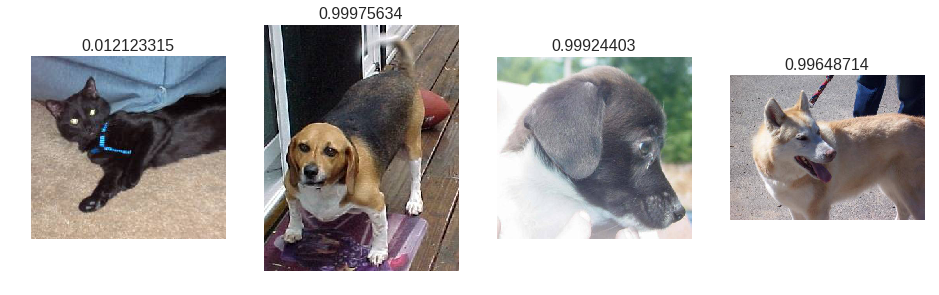

In [0]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(True), "Correctly classified")


Incorrectly classified


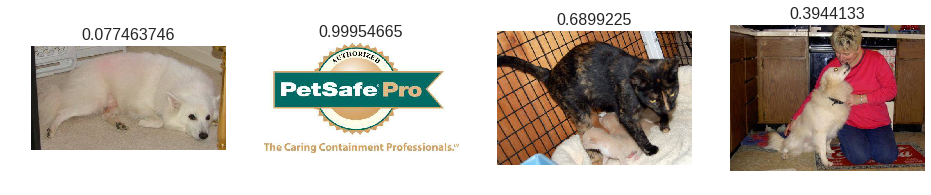

In [0]:

# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


Most correct cats


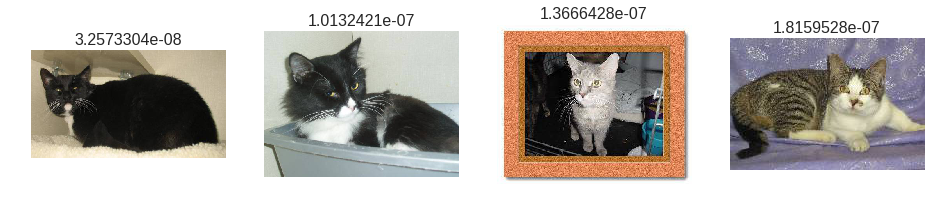

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")


Most uncertain predictions


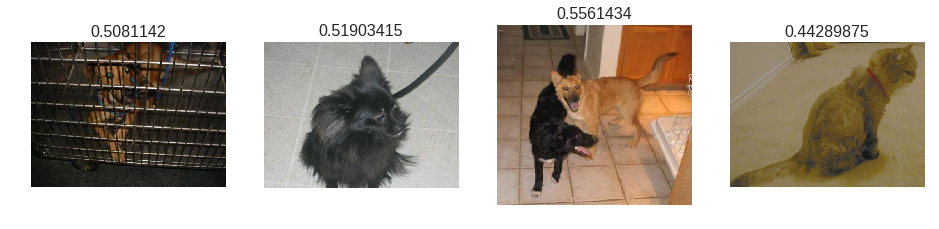

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
#create a new learner since we want to know how to set the learning rate for a new untrained model

In [0]:
lrf = learn.lr_find() # It helps find the optimal learning rate
#using cyclical learning rates - where we simply keep increasing the lr from a small value until the loss stops decreasing.
#The learning rate finder will increase the lr after each mini-batch. 
#the learning rate says how slowly you want to update the weights/parameters

 85%|████████▍ | 305/360 [00:07<00:01, 50.31it/s, loss=0.476]


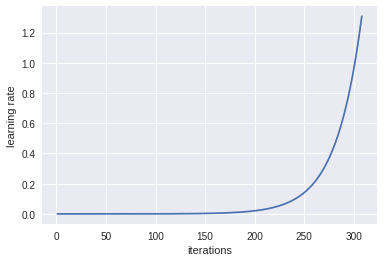

In [0]:
learn.sched.plot_lr()

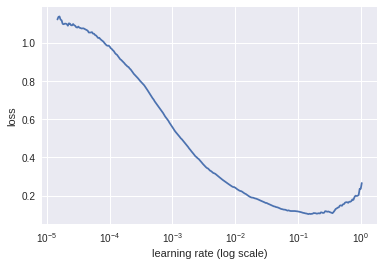

In [0]:
# We know plot the learning rate against against loss and go back by one magnitue and pick that learning rate.

learn.sched.plot()

In [0]:
learn.fit(0.01, 3) # the first param is the learning rate and the second is the epoch numb

epoch      trn_loss   val_loss   accuracy   
    0      0.057683   0.029851   0.989     
    1      0.051843   0.02719    0.99      
    2      0.036164   0.029643   0.988     



[array([0.02964]), 0.988]

In [0]:
?learn # gets arguments and more

In [0]:
??learn # get source code

In [0]:
#After you train your model over more epochs it starts to overfit.
#One way to overcome overfitting is by creating more data. And we can do that with data augmentation.
#This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.
#to do this we pass aug_tfms to tfms_from_model and specify a list of ways we want to change the image

#For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos 
#taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. 
#We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)


In [0]:
#this allows our cnn to learn from diff angles
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)
#the augmentations do nothing because of precompute=true


epoch      trn_loss   val_loss   accuracy   
    0      0.048294   0.029268   0.9905    



[array([0.02927]), 0.9905]

Convolutional neural network have these things called “activations.” **An activation is a number that says “this feature is in this place with this level of confidence (probability)”.** We are using a pre-trained network which has already learned to recognize features (i.e. we do not want to change hyper parameters it learned), so what we can do is to pre-compute activations for hidden layers and just train the final linear portion.

This is why when you train your model for the first time, it takes longer — it is pre-computing these activations.
Even though we are trying to show a different version of the cat each time, we had already pre-computed the activations for a particular version of the cat (i.e. we are not re-calculating the activations with the altered version).
To use data augmentation, we have to do learn.precompute=False:

In [0]:
learn.precompute = False
#be default when we create a learner it freezes all the layers apart from the last, meaning when we call fit it is just updating the weights
#of the last layer

The idea of decreasing the learning rate as you train is called learning rate annealing which is very common. Most common and “hacky” way to do this is to train a model with a certain learning rate for a while, and when it stops improving, manually drop down the learning rate (stepwise annealing).

A better approach is simply to pick some kind of functional form — turns out the really good functional form is one half of the cosign curve which maintains the high learning rate for a while at the beginning, then drop quickly when you get closer.

![alt text](https://cdn-images-1.medium.com/max/1500/1*xmIlOee7PWLc6fa7xdfRkA.png)

In [0]:
learn.fit(1e-2, 3, cycle_len=1)
#the cycle_len param: We are using stochastic gradient descent with restarts, a variant of learning rate annealing, which gradually
#decreases the learning rate. Because we want to take smaller steps as we get closer to optimal weights.
#BUT! we might find ourselves in a weight space that isn't very resilient (may not generalise well might be very spikey), that is small changes to
#the weights may result in a big change to the loss. Thus, from time to time we increase the learning rate (this is the restarts), which will
#force the model to jump to a different part of the weight space if the current area is spikey. See figure below.

epoch      trn_loss   val_loss   accuracy   
    0      0.039912   0.028656   0.9905    
    1      0.037765   0.029346   0.99      
    2      0.039656   0.029065   0.9895    



[array([0.02907]), 0.9895]

![alt text](https://github.com/fastai/fastai/raw/fde064af745553d3c2ecceef3c90a0ab0563044b/courses/dl1/images/sgdr.png)

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what our actual learning rates looked like:

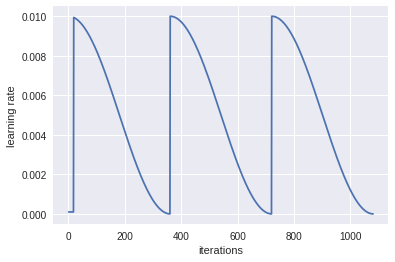

In [0]:
learn.sched.plot_lr()

“Snapshot Ensemble” in the diagram. We are not currently doing that but if you wanted it to generalize even better, you can save the weights right before the resets and take the average. But for now, we are just going to pick the last one.
If you want to skip ahead, there is a parameter called cycle_save_name which you can add as well as cycle_len, which will save a set of weights at the end of every learning rate cycle and then you can ensemble them 

In [0]:
learn.save("224_lastlayer")


In [0]:
learn.load("224_lastlayer")

In [0]:
#now we're going to do fine-tuning and set differential learning rates
#so far we havent retrained any of the pretrained features - that is the weights of the conv kernels.
#All we've done is add some layers on top and learned how to mix and match pretrained features.
#Now we have a good final layer we can try fine-tuning the other layers.
#to tell the learner we want to start changing the conv filters themselves we do learn.unfreeze()
learn.unfreeze()


Note that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) (diagonal edges or gradient) (second layer recognises corners or curvers - these layers dont need much changing at all) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [0]:
lr = np.array([1e-4, 1e-3, 1e-2])

1e-4 : for the first few layers (basic geometric features)
1e-3 : for the middle layers (sophisticated convolutional features)
1e-2 : for layers we added on top
Why 3? Actually they are 3 ResNet blocks but for now, think of it as a group of layers.

Earlier we said 3 is the number of epochs, but it is actually cycles. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult
cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

Intuitively speaking [53:57], if the cycle length is too short, it starts going down to find a good spot, then pops out, and goes down trying to find a good spot and pops out, and never actually get to find a good spot. Earlier on, you want it to do that because it is trying to find a spot that is smoother, but later on, you want it to do more exploring. That is why cycle_mult=2 seems to be a good approach.

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.049117   0.025739   0.99      
    1      0.042902   0.022709   0.9925    
    2      0.04372    0.023055   0.992     
    3      0.028289   0.019178   0.9925    
    4      0.025493   0.020893   0.991     
    5      0.020105   0.019514   0.994     
    6      0.019671   0.019363   0.993     



[array([0.01936]), 0.993]

Question: why do smoother surfaces correlate to more generalized networks? 

![alt text](https://cdn-images-1.medium.com/max/1200/1*fNvevN5qLDf9dgq4632J7A.png)

Say you have something spiky (blue line). X-axis is showing how good this is at recognizing dogs vs. cats as you change this particular parameter. Something to be generalizable means that we want it to work when we give it a slightly different dataset. Slightly different dataset may have a slightly different relationship between this parameter and how cat-like vs. dog-like it is. It may, instead look like the red line. In other words, if we end up at the blue pointy part, then it will not going to do a good job on this slightly different dataset. Or else, if we end up on the wider blue part, it will still do a good job on the red dataset.

In [0]:
learn.save("224_all")

In [0]:
learn.load("224_all")

We are going to do what is called “Test Time Augmentation”. What this means is that we are going to take 4 data augmentations at random as well as the un-augmented original (center-cropped). We will then calculate predictions for all these images, take the average, and make that our final prediction. Note that this is only for validation set and/or test set.

In [0]:
#There is something we can do with data augmentation at inference/test time. I.e. TTA.
#TTA simply makes predictions not only on the images in your validation but also makes predictions on different randomly augmented versions of them.
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [0]:
accuracy_np(probs, y)

0.9925

In [0]:
#Now we will analyze the results with a confusion matrix
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, preds)

[[993   7]
 [  8 992]]


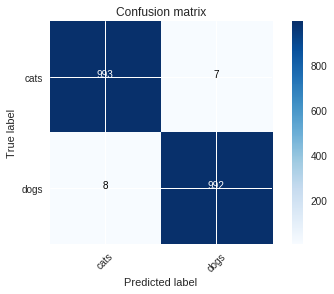

In [0]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


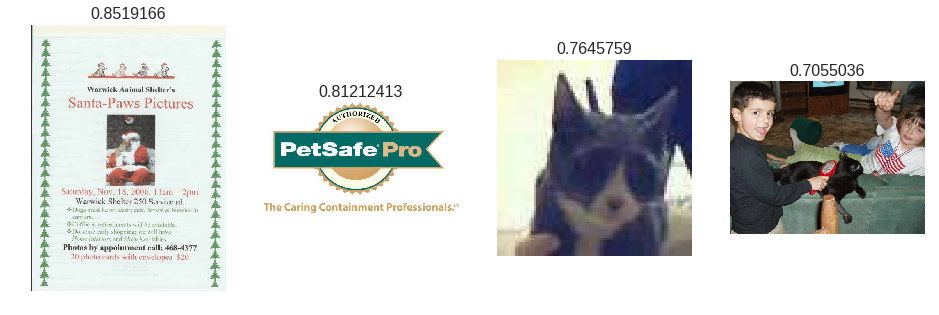

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")


When we run learn.fit we print 3 performance values (see above.) Here 0.03 is the value of the loss in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

Accuracy is the ratio of correct prediction to the total number of predictions.

In machine learning the loss function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by: -(y * log(p) + (1-y) * log (1-p)) where y is the true label of x and p is the probability predicted by our model that the label is 1.




    
    
    

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))
  
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)


0.164252033486018

In [0]:
#Dog breeds
!pip install kaggle-cli --upgrade

Replace <username>, <password> with your credential and <competition> is what follows /c/ in the URL. For example, if you are trying to download dog breed data from https://www.kaggle.com/c/dog-breed-identification the command would look like:

In [0]:
#kg download -u <username> -p <password> -c <competition>
!kg download -u parulian.saragi@accenture.com -p Archie5129 -c dog-breed-identification/data